# CMPINF 2100: Final exam - Model and Performance

## VASANTH MADHAVAN SRINIVASA RAGHAVAN

First Name: VASANTH MADHAVAN | Last Name: SRINIVASA RAGHAVAN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
import statsmodels.formula.api as smf\

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [2]:
sns.set_palette("colorblind")

In [3]:
songs_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

df = pd.read_csv(songs_url)

In [4]:
df.shape

(32833, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [6]:
df.nunique()

track_id                    28356
track_name                  23449
track_artist                10692
track_popularity              101
track_album_id              22545
track_album_name            19743
track_album_release_date     4530
playlist_name                 449
playlist_id                   471
playlist_genre                  6
playlist_subgenre              24
danceability                  822
energy                        952
key                            12
loudness                    10222
mode                            2
speechiness                  1270
acousticness                 3731
instrumentalness             4729
liveness                     1624
valence                      1362
tempo                       17684
duration_ms                 19785
dtype: int64

In [7]:
df.dtypes

track_id                     object
track_name                   object
track_artist                 object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
dtype: object

In [8]:
# Create a target variable - track_populairy_bin (y)

df['track_popularity_bin'] = np.where( df.track_popularity > 50, 1, 0 )
df = df.astype({'track_popularity_bin': 'object'})
df.track_popularity_bin.value_counts(normalize=True)

track_popularity_bin
0    0.574757
1    0.425243
Name: proportion, dtype: float64

## Modeling - Pre-modeling activities

#### Data Cleanup

In [9]:
#  Removing duplicates - More details in the EDA notebook

df.drop_duplicates(subset=['track_id'], keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28356 entries, 0 to 32832
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  28356 non-null  object 
 1   track_name                28352 non-null  object 
 2   track_artist              28352 non-null  object 
 3   track_popularity          28356 non-null  int64  
 4   track_album_id            28356 non-null  object 
 5   track_album_name          28352 non-null  object 
 6   track_album_release_date  28356 non-null  object 
 7   playlist_name             28356 non-null  object 
 8   playlist_id               28356 non-null  object 
 9   playlist_genre            28356 non-null  object 
 10  playlist_subgenre         28356 non-null  object 
 11  danceability              28356 non-null  float64
 12  energy                    28356 non-null  float64
 13  key                       28356 non-null  int64  
 14  loudness   

In [10]:
# Remove identifier columns

df.drop(['track_id','track_album_id','playlist_id','track_artist','playlist_name', 'track_name', 'track_album_name'],
        inplace=True,
        axis=1)

In [11]:
# Remove `playlist_subgenre` as it is high correlated with `playlist_genre`

df.drop(columns=['playlist_subgenre'], inplace=True)

In [12]:
# Drop `track_album_release_date` 

df.drop(columns=['track_album_release_date'], inplace=True)

#### Addressing Skewness

In [13]:
df_features = df.select_dtypes('number').copy()
df_features.drop(['track_popularity'], axis=1, inplace=True)

In [14]:
df_objects = df.select_dtypes('object').copy()

In [15]:
id_cols = ['rowid', 'track_popularity'] + df_objects.columns.to_list()

In [16]:
df_lf = df.reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=id_cols, value_vars=df_features.columns)

In [17]:
df_lf

,rowid,track_popularity,playlist_genre,track_popularity_bin,variable,value
0,0,66,pop,1,danceability,0.748
1,1,67,pop,1,danceability,0.726
2,2,70,pop,1,danceability,0.675
3,3,60,pop,1,danceability,0.718
4,4,69,pop,1,danceability,0.650
...,...,...,...,...,...,...
340267,32828,42,edm,0,duration_ms,204375.000
340268,32829,20,edm,0,duration_ms,353120.000
340269,32830,14,edm,0,duration_ms,210112.000
340270,32831,15,edm,0,duration_ms,367432.000


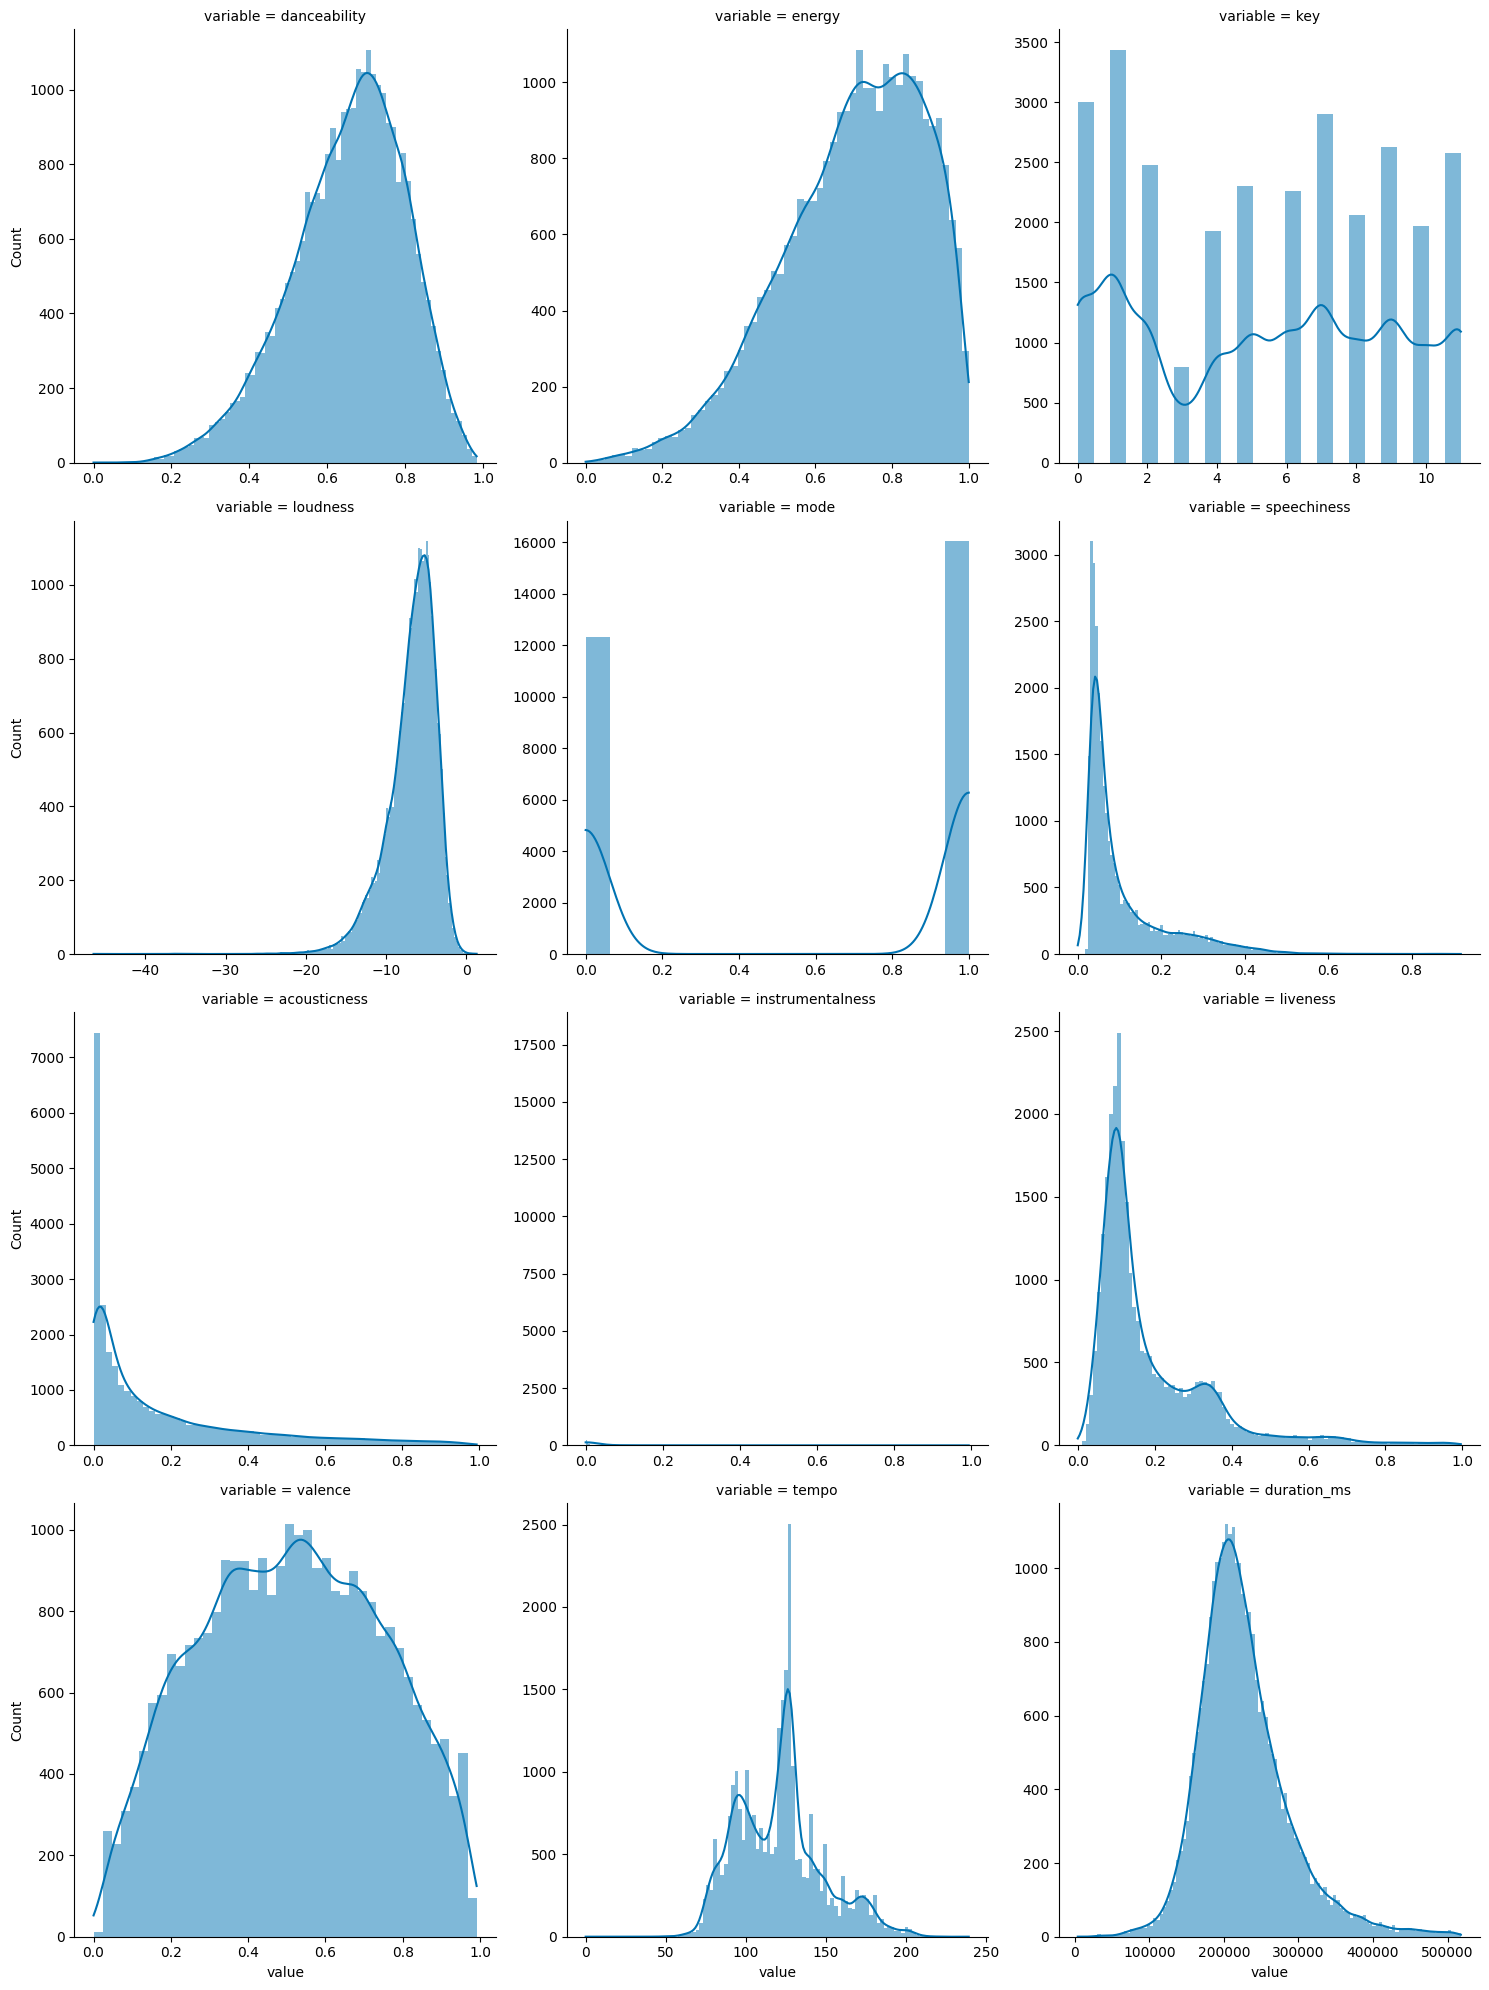

In [18]:
sns.displot(data = df_lf, x='value', col='variable', kind='hist', kde=True,
            facet_kws={'sharex': False, 'sharey': False},
            common_bins=False,
            col_wrap=3)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.tight_layout()
plt.show()

In [19]:
# Reducing skewness by applying log transform

df['speechiness_log'] = df['speechiness'].apply(lambda x: np.log(x) if x > 0 else 0)
df['acousticness_log'] = df['acousticness'].apply(lambda x: np.log(x) if x > 0 else 0)
df['instrumentalness_log'] = df['instrumentalness'].apply(lambda x: np.log(x) if x > 0 else 0)
df['liveness_log'] = df['liveness'].apply(lambda x: np.log(x) if x > 0 else 0)
df['duration_ms_log'] = df['duration_ms'].apply(lambda x: np.log(x) if x > 0 else 0)

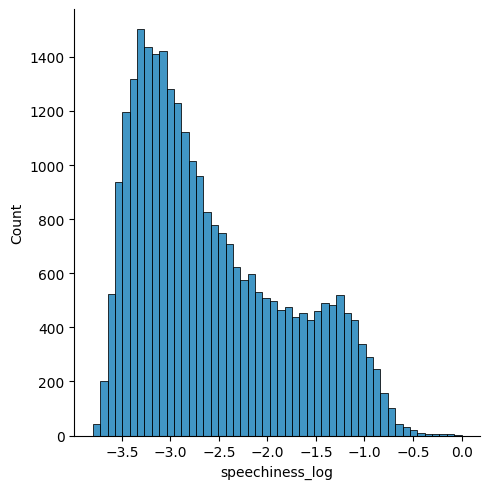

In [20]:
sns.displot(data = df, x='speechiness_log', kind='hist')

plt.show()

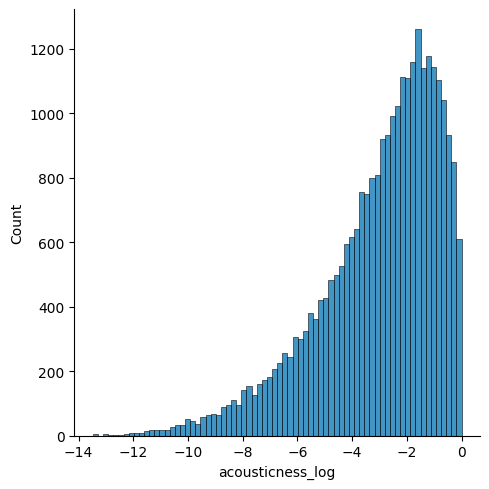

In [21]:
sns.displot(data = df, x='acousticness_log', kind='hist')

plt.show()

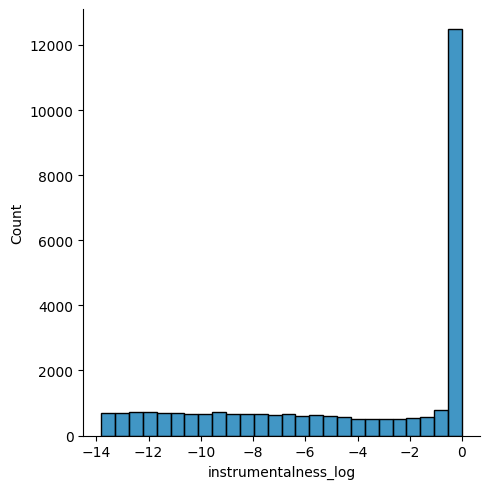

In [22]:
sns.displot(data = df, x='instrumentalness_log', kind='hist')

plt.show()

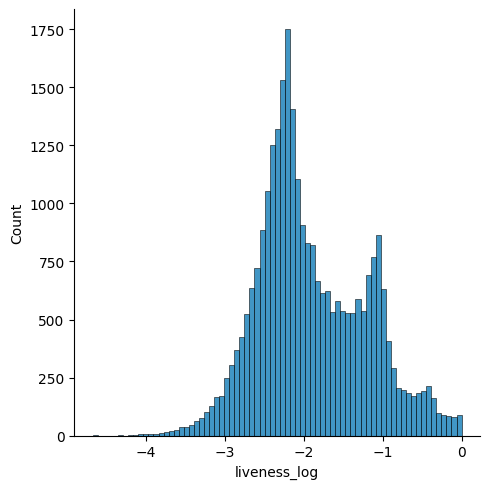

In [23]:
sns.displot(data = df, x='liveness_log', kind='hist')

plt.show()

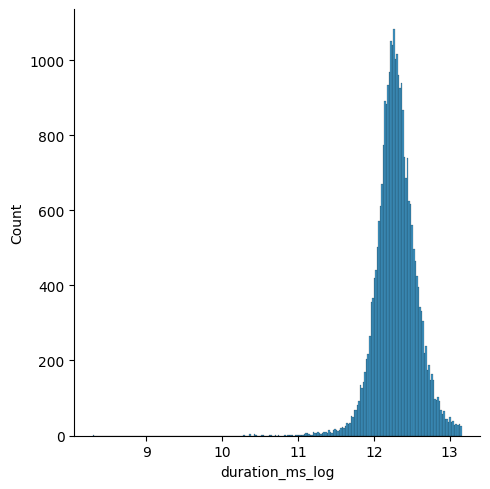

In [24]:
sns.displot(data = df, x='duration_ms_log', kind='hist')

plt.show()

## Modeling - Fitting models

### Fitting

Define a function to FIT and CALCULATE the training set performance

In [25]:
def fit_and_assess_logistic(mod_name, a_formula, train_data, threshold):
    a_mod = smf.logit(formula=a_formula, data=train_data).fit()

    train_copy = train_data.copy()

    train_copy['pred_probability'] = a_mod.predict(train_data)

    train_copy['pred_class'] = np.where(train_copy.pred_probability > threshold, 1, 0 )

    TN, FP, FN, TP = confusion_matrix(train_copy.y.to_numpy(), train_copy.pred_class.to_numpy() ).ravel()

    Accuracy = (TN + TP) / (TN + FP + FN + TP)

    Sensitivity = (TP) / (TP + FN)

    Specificity = (TN) / (TN + FP)

    FPR = 1 - Specificity

    ROC_AUC = roc_auc_score(train_copy.y.to_numpy(), train_copy.pred_probability.to_numpy() )

    res_dict = {'model_name': mod_name,
                'model_formula': a_formula,
                'num_coefs': len( a_mod.params ),
                'threshold': threshold,
                'Accuracy': Accuracy,
                'Sensitivity': Sensitivity,
                'Specificity': Specificity,
                'FPR': FPR,
                'ROC_AUC': ROC_AUC}

    return pd.DataFrame( res_dict, index=[0] )

In [26]:
df['y'] = df['track_popularity_bin']
df = df.astype({'y': 'int'})

In [45]:
df.drop(columns=['track_popularity_bin', 'track_popularity'], inplace=True)
df

,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,speechiness_log,acousticness_log,instrumentalness_log,liveness_log,duration_ms_log,y
0,pop,0.748,0.916,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754,-2.842153,-2.282782,0.000000,-2.728763,12.179493,1
1,pop,0.726,0.815,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600,-3.288762,-2.625549,-5.470293,-1.030019,11.999048,1
2,pop,0.675,0.931,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616,-2.600991,-2.533257,-10.667057,-2.207275,12.081733,1
3,pop,0.718,0.930,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093,-2.282782,-3.550858,-11.571614,-1.589635,12.038204,1
4,pop,0.650,0.833,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052,-3.327018,-2.521986,0.000000,-2.485307,12.149777,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,edm,0.428,0.922,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375,-2.368725,-2.569158,0.000000,-2.706052,12.227712,0
32829,edm,0.522,0.786,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120,-3.170086,-6.371262,-5.456141,-0.980829,12.774563,0
32830,edm,0.529,0.821,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112,-3.034473,-2.225624,-13.711151,-1.897120,12.255396,0
32831,edm,0.626,0.888,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432,-2.216407,-4.838364,-2.063568,-1.070025,12.814294,0


In [46]:
fit_and_assess_logistic(0, 'y ~ 1', train_data=df, threshold=0.5)

Optimization terminated successfully.
         Current function value: 0.659223
         Iterations 4


,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,0,y ~ 1,1,0.5,0.629496,0.0,1.0,0.0,0.5


In [47]:
formula_list = [
    # Intercept Only
    'y ~ 1',
    # Categorical inputs with additive features
    'y ~ playlist_genre + key + mode',
    # Continuous inputs with linear additive features
    'y ~ tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log',
    # All Inputs
    'y ~ playlist_genre + key + mode + tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log',
    # Continuous inputs with linear main effect and pair-wise interactions.
    'y ~ (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log) ** 2',
    # Interact the categorical inputs with the continuous inputs. This model must include the linear main effects as well (the formula interface helps with the interactions).
    'y ~ playlist_genre * (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log)',
    # Based on EDA
    'y ~ mode * (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log)',
    'y ~ playlist_genre * ( (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log)**2 + np.power(tempo,2) + np.power(loudness,2) + np.power(valence,2) + np.power(danceability,2) + np.power(energy,2) + np.power(duration_ms_log,2) + np.power(speechiness_log,2) + np.power(instrumentalness_log,2) + np.power(liveness_log,2) + np.power(acousticness_log,2))',
]


In [48]:
results_list=[]
for x in range(len(formula_list)):
    results_list.append(
        fit_and_assess_logistic(x, formula_list[x], train_data = df, threshold=0.5) )

Optimization terminated successfully.
         Current function value: 0.659223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597308
         Iterations 15


In [49]:
results_df = pd.concat(results_list, ignore_index=True)
results_df

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,0,y ~ 1,1,0.5,0.629496,0.000000,1.000000,0.000000,0.500000
1,1,y ~ playlist_genre + key + mode,8,0.5,0.629496,0.000000,1.000000,0.000000,0.614164
2,2,y ~ tempo + loudness + valence + danceability ...,11,0.5,0.631471,0.094993,0.947227,0.052773,0.611263
3,3,y ~ playlist_genre + key + mode + tempo + loud...,18,0.5,0.645013,0.246907,0.879328,0.120672,0.661755
4,4,y ~ (tempo + loudness + valence + danceability...,56,0.5,0.638489,0.138778,0.932605,0.067395,0.629157
5,5,y ~ playlist_genre * (tempo + loudness + valen...,66,0.5,0.657215,0.283267,0.877311,0.122689,0.677108
6,6,y ~ mode * (tempo + loudness + valence + dance...,22,0.5,0.632741,0.103560,0.944202,0.055798,0.613896
7,7,y ~ playlist_genre * ( (tempo + loudness + val...,396,0.5,0.669453,0.360937,0.851036,0.148964,0.701659


In [50]:
results_df.sort_values(by=['Accuracy'], ascending=False)

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
7,7,y ~ playlist_genre * ( (tempo + loudness + val...,396,0.5,0.669453,0.360937,0.851036,0.148964,0.701659
5,5,y ~ playlist_genre * (tempo + loudness + valen...,66,0.5,0.657215,0.283267,0.877311,0.122689,0.677108
3,3,y ~ playlist_genre + key + mode + tempo + loud...,18,0.5,0.645013,0.246907,0.879328,0.120672,0.661755
4,4,y ~ (tempo + loudness + valence + danceability...,56,0.5,0.638489,0.138778,0.932605,0.067395,0.629157
6,6,y ~ mode * (tempo + loudness + valence + dance...,22,0.5,0.632741,0.103560,0.944202,0.055798,0.613896
2,2,y ~ tempo + loudness + valence + danceability ...,11,0.5,0.631471,0.094993,0.947227,0.052773,0.611263
0,0,y ~ 1,1,0.5,0.629496,0.000000,1.000000,0.000000,0.500000
1,1,y ~ playlist_genre + key + mode,8,0.5,0.629496,0.000000,1.000000,0.000000,0.614164


In [51]:
results_df.sort_values(by=['ROC_AUC'], ascending=False)

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
7,7,y ~ playlist_genre * ( (tempo + loudness + val...,396,0.5,0.669453,0.360937,0.851036,0.148964,0.701659
5,5,y ~ playlist_genre * (tempo + loudness + valen...,66,0.5,0.657215,0.283267,0.877311,0.122689,0.677108
3,3,y ~ playlist_genre + key + mode + tempo + loud...,18,0.5,0.645013,0.246907,0.879328,0.120672,0.661755
4,4,y ~ (tempo + loudness + valence + danceability...,56,0.5,0.638489,0.138778,0.932605,0.067395,0.629157
1,1,y ~ playlist_genre + key + mode,8,0.5,0.629496,0.000000,1.000000,0.000000,0.614164
6,6,y ~ mode * (tempo + loudness + valence + dance...,22,0.5,0.632741,0.103560,0.944202,0.055798,0.613896
2,2,y ~ tempo + loudness + valence + danceability ...,11,0.5,0.631471,0.094993,0.947227,0.052773,0.611263
0,0,y ~ 1,1,0.5,0.629496,0.000000,1.000000,0.000000,0.500000


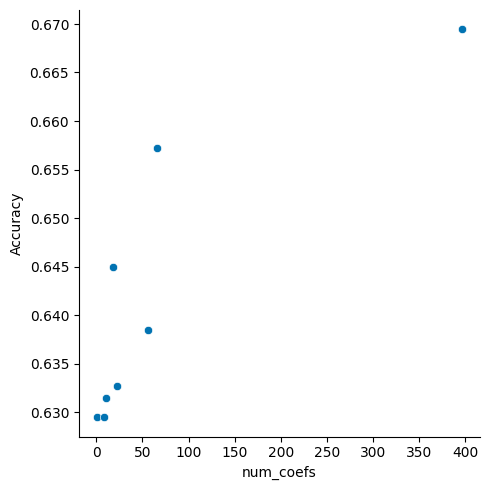

In [52]:
sns.relplot(data = results_df, x='num_coefs', y='Accuracy', kind='scatter')

plt.show()

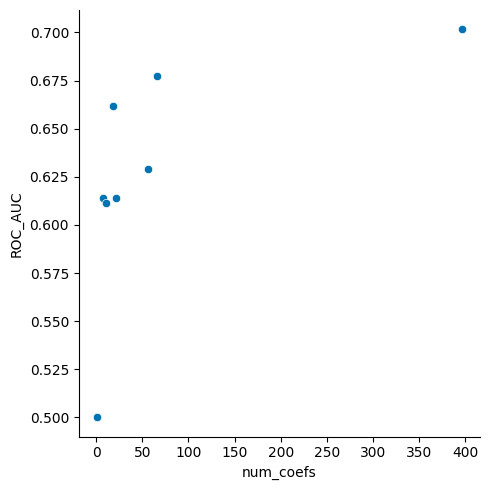

In [53]:
sns.relplot(data = results_df, x='num_coefs', y='ROC_AUC', kind='scatter')

plt.show()

Model performance gets better with more coefficients

### Best Performing Model
* **model_name**: 7
* **model_formula**: `y ~ playlist_genre * ( (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log)**2 + np.power(tempo,2) + np.power(loudness,2) + np.power(valence,2) + np.power(danceability,2) + np.power(energy,2) + np.power(duration_ms_log,2) + np.power(speechiness_log,2) +                np.power(instrumentalness_log,2) + np.power(liveness_log,2) + np.power(acousticness_log,2))`
* **Accuracy Vs ROC** - In this case the model doesn't change between Accuracy Vs ROC. It is still model 7
* **No. of coefs**: 396
* The best model performs **better** than INTERCEPT-ONLY model

### Visualize the entire ROC curve for each model

In [54]:
def fit_logistic_make_roc(mod_name, a_formula, train_data):
    a_mod = smf.logit(formula=a_formula, data=train_data).fit()
    
    train_copy = train_data.copy()
    
    train_copy['pred_probability'] = a_mod.predict( train_data )
    
    fpr, tpr, threshold = roc_curve( train_data.y.to_numpy(), train_copy.pred_probability.to_numpy() )
    
    res_df = pd.DataFrame({'tpr': tpr,
                           'fpr': fpr,
                           'threshold': threshold})
    
    res_df['model_name'] = mod_name
    res_df['model_formula'] = a_formula
    
    return res_df

In [56]:
roc_list = []

for m in range( len(formula_list) ):
    roc_list.append( fit_logistic_make_roc( m, formula_list[m], train_data=df))

Optimization terminated successfully.
         Current function value: 0.659223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597308
         Iterations 15


In [57]:
roc_df = pd.concat( roc_list, ignore_index=True )
roc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75759 entries, 0 to 75758
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tpr            75759 non-null  float64
 1   fpr            75759 non-null  float64
 2   threshold      75759 non-null  float64
 3   model_name     75759 non-null  int64  
 4   model_formula  75759 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ MB


In [58]:
roc_df['model_name'] = roc_df.model_name.astype('category')
roc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75759 entries, 0 to 75758
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tpr            75759 non-null  float64 
 1   fpr            75759 non-null  float64 
 2   threshold      75759 non-null  float64 
 3   model_name     75759 non-null  category
 4   model_formula  75759 non-null  object  
dtypes: category(1), float64(3), object(1)
memory usage: 2.4+ MB


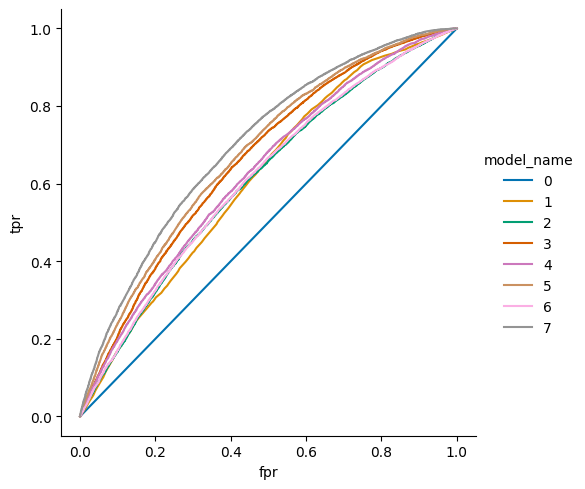

In [74]:
sns.relplot(data = roc_df, x='fpr', y='tpr', hue='model_name',
            kind='line', estimator=None,)

plt.show()

### Identifying statistically significant features

In [62]:
# Model with all features
model_all_feat = smf.logit(formula=formula_list[3], data=df).fit()

Optimization terminated successfully.
         Current function value: 0.620351
         Iterations 6


In [88]:
print(model_all_feat.pvalues[model_all_feat.pvalues < 0.05].sort_values().to_string())

playlist_genre[T.pop]      2.617667e-184
playlist_genre[T.rock]     1.223407e-158
loudness                   5.572640e-108
playlist_genre[T.rap]       3.086667e-84
playlist_genre[T.latin]     5.867846e-78
energy                      3.397391e-60
playlist_genre[T.r&b]       2.052120e-35
Intercept                   6.860019e-16
acousticness_log            1.010851e-15
duration_ms_log             3.554137e-15
danceability                3.869361e-10
tempo                       1.036601e-06


In [76]:
# Best performing model
model_best = smf.logit(formula=formula_list[7], data=df).fit()

Optimization terminated successfully.
         Current function value: 0.597308
         Iterations 15


In [87]:
print(model_best.pvalues[model_best.pvalues < 0.05].sort_values().to_string())

playlist_genre[T.pop]:tempo:speechiness_log                 0.000038
playlist_genre[T.rap]:tempo:speechiness_log                 0.000046
playlist_genre[T.latin]:tempo:speechiness_log               0.000074
playlist_genre[T.pop]:np.power(loudness, 2)                 0.000110
playlist_genre[T.r&b]:tempo:speechiness_log                 0.000139
playlist_genre[T.rock]:danceability:instrumentalness_log    0.000164
tempo:speechiness_log                                       0.000210
duration_ms_log                                             0.000693
valence:instrumentalness_log                                0.000765
np.power(duration_ms_log, 2)                                0.000943
playlist_genre[T.rock]:tempo:valence                        0.001122
Intercept                                                   0.001265
playlist_genre[T.latin]:valence:instrumentalness_log        0.001375
playlist_genre[T.rock]:loudness:duration_ms_log             0.001454
loudness:duration_ms_log          

In [111]:
# Second best performing model
model_5 = smf.logit(formula=formula_list[5], data=df).fit()

Optimization terminated successfully.
         Current function value: 0.612935
         Iterations 7


In [112]:
print(model_5.pvalues[model_5.pvalues < 0.05].sort_values().to_string())

playlist_genre[T.rap]:danceability         4.200215e-14
Intercept                                  1.643470e-10
playlist_genre[T.rock]                     3.455261e-10
duration_ms_log                            8.318247e-10
playlist_genre[T.rock]:duration_ms_log     1.990475e-09
loudness                                   4.648723e-08
acousticness_log                           5.502261e-08
playlist_genre[T.rock]:acousticness_log    1.567145e-07
playlist_genre[T.latin]:duration_ms_log    1.896423e-07
playlist_genre[T.latin]                    3.817529e-06
playlist_genre[T.r&b]:valence              9.812608e-06
energy                                     2.493741e-05
playlist_genre[T.pop]:speechiness_log      1.232495e-04
playlist_genre[T.rap]                      1.789994e-04
playlist_genre[T.rap]:valence              2.230364e-04
playlist_genre[T.pop]:danceability         5.309010e-04
playlist_genre[T.rock]:liveness_log        7.486233e-04
playlist_genre[T.rap]:duration_ms_log      1.480

## Predictions

In [92]:
df.describe(include=object)

,playlist_genre
count,28356
unique,6
top,rap
freq,5401


In [93]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,speechiness_log,acousticness_log,instrumentalness_log,liveness_log,duration_ms_log,y
count,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000,28356.00000,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000,28356.000000
mean,0.653372,0.698388,5.368000,-6.817696,0.565489,0.107954,0.177176,0.091117,0.190958,0.510387,120.95618,226575.967026,-2.562168,-3.044614,-4.198872,-1.908728,12.296231,0.370504
std,0.145785,0.183503,3.613904,3.036243,0.495701,0.102556,0.222803,0.232548,0.155894,0.234340,26.95456,61078.450819,0.775959,2.225113,4.681524,0.688639,0.264864,0.482948
min,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,4000.000000,-3.798694,-13.479038,-13.815511,-4.671310,8.294050,0.000000
25%,0.561000,0.579000,2.000000,-8.309250,0.000000,0.041000,0.014375,0.000000,0.092600,0.329000,99.97200,187742.000000,-3.194183,-4.240527,-8.381789,-2.379466,12.142824,0.000000
50%,0.670000,0.722000,6.000000,-6.261000,1.000000,0.062600,0.079700,0.000021,0.127000,0.512000,121.99300,216933.000000,-2.770990,-2.529486,-1.937942,-2.063568,12.287344,0.000000
75%,0.760000,0.843000,9.000000,-4.709000,1.000000,0.133000,0.260000,0.006570,0.249000,0.695000,133.99900,254975.250000,-2.017406,-1.347074,0.000000,-1.390302,12.448922,1.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.44000,517810.000000,0.000000,0.000000,0.000000,0.000000,13.157364,1.000000


In [105]:
input_grid = pd.DataFrame([(playlist_genre, danceability, energy, key, loudness, mode, valence, tempo, speechiness_log, acousticness_log, instrumentalness_log, liveness_log, duration_ms_log) 
                           for playlist_genre in df.playlist_genre.unique()
                           for danceability in [df.danceability.mean()]
                           for energy in [df.energy.mean()]
                           for key in df.key.mode()
                           for loudness in np.linspace(df.loudness.min(), df.loudness.max(), num=5)
                           for mode in df['mode'].mode()
                           for valence in [df.valence.mean()]
                           for tempo in [df.tempo.mean()]
                           for speechiness_log in [df.speechiness_log.mean()]
                           for acousticness_log in [df.acousticness_log.mean()]
                           for instrumentalness_log in [df.instrumentalness_log.mean()]
                           for liveness_log in [df.liveness_log.mean()]
                           for duration_ms_log in np.linspace(df.duration_ms_log.min(), df.duration_ms_log.max(), num=101)
                          ],
                          columns=['playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'valence', 'tempo', 'speechiness_log', 'acousticness_log', 'instrumentalness_log', 'liveness_log', 'duration_ms_log'])

In [108]:
input_grid.nunique()

playlist_genre            6
danceability              1
energy                    1
key                       1
loudness                  5
mode                      1
valence                   1
tempo                     1
speechiness_log           1
acousticness_log          1
instrumentalness_log      1
liveness_log              1
duration_ms_log         101
dtype: int64

In [113]:
model_all_feat = smf.logit(formula=formula_list[3], data=df).fit()

Optimization terminated successfully.
         Current function value: 0.620351
         Iterations 6


In [ ]:
model_best = smf.logit(formula=formula_list[3], data=df).fit()